<a href="https://colab.research.google.com/github/RA2112704010029/APPLIED-DEEP-LEARNING-/blob/main/ChallengeQuestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code tells us the difference between the working of RNN, LSTM and GRU


Training RNN (Exploding Gradients Expected)
RNN - Epoch [0/50], Loss: 0.1016, Grad Norm: 1.2540
RNN - Epoch [10/50], Loss: 0.0180, Grad Norm: 1.0299
RNN - Epoch [20/50], Loss: 0.0172, Grad Norm: 0.8918
RNN - Epoch [30/50], Loss: 0.0183, Grad Norm: 0.6916
RNN - Epoch [40/50], Loss: 0.0176, Grad Norm: 1.1966

Training LSTM (Improved with Gradient Clipping)
LSTM (Improved) - Epoch [0/50], Loss: 0.2574, Grad Norm: 12.9671
LSTM (Improved) - Epoch [10/50], Loss: 0.0284, Grad Norm: 4.0435
LSTM (Improved) - Epoch [20/50], Loss: 0.0209, Grad Norm: 0.2203
LSTM (Improved) - Epoch [30/50], Loss: 0.0178, Grad Norm: 1.8424
LSTM (Improved) - Epoch [40/50], Loss: 0.0169, Grad Norm: 1.7083

Training GRU (Improved with Gradient Clipping)
GRU (Improved) - Epoch [0/50], Loss: 0.2836, Grad Norm: 0.2757
GRU (Improved) - Epoch [10/50], Loss: 0.0280, Grad Norm: 0.6134
GRU (Improved) - Epoch [20/50], Loss: 0.0174, Grad Norm: 1.9235
GRU (Improved) - Epoch [30/50], Loss: 0.0155, Grad Norm: 1.4053
GRU (Improved)

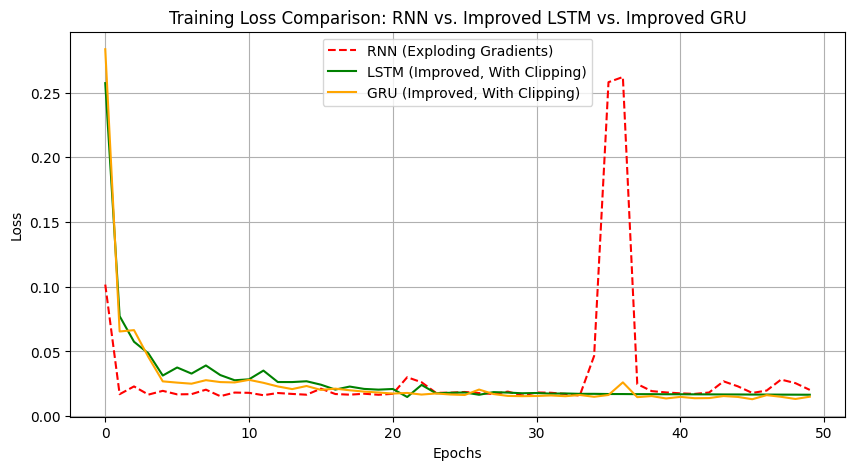

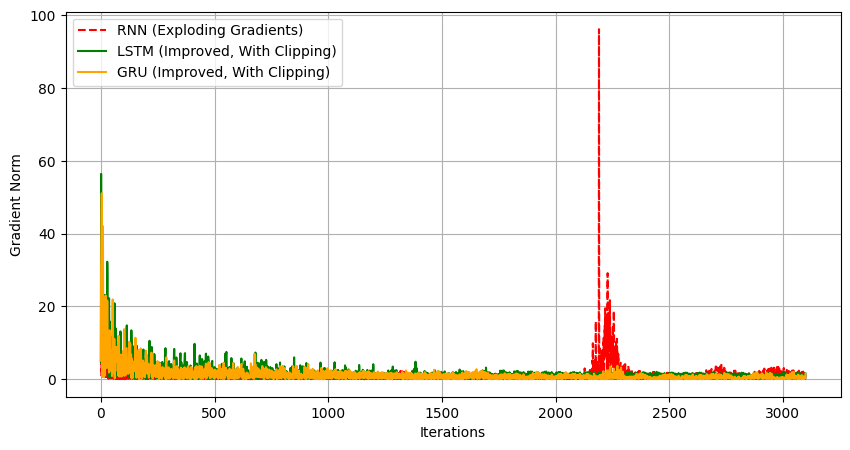

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

def generate_data(seq_length, num_samples):
    x = np.linspace(0, 50, num_samples)
    y = np.sin(x) + 0.1 * np.random.randn(num_samples)
    sequences, targets = [], []
    for i in range(len(y) - seq_length):
        sequences.append(y[i:i + seq_length])
        targets.append(y[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length, num_samples = 10, 1000
input_size, hidden_size_rnn, hidden_size_lstm_gru, epochs, batch_size = 1, 20, 40, 50, 16

X, Y = generate_data(seq_length, num_samples)
X = X.reshape(-1, seq_length, 1)
Y = Y.reshape(-1, 1)

X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size_rnn)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ImprovedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0, c0 = torch.zeros(2, x.size(0), hidden_size_lstm_gru), torch.zeros(2, x.size(0), hidden_size_lstm_gru)
        out, _ = self.lstm(x, (h0, c0))
        out = self.norm(out[:, -1, :])
        return self.fc(out)

class ImprovedGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ImprovedGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), hidden_size_lstm_gru)
        out, _ = self.gru(x, h0)
        out = self.norm(out[:, -1, :])
        return self.fc(out)

rnn = SimpleRNN(input_size, hidden_size_rnn)
lstm = ImprovedLSTM(input_size, hidden_size_lstm_gru)
gru = ImprovedGRU(input_size, hidden_size_lstm_gru)

optimizer_rnn = optim.Adam(rnn.parameters(), lr=0.01)
optimizer_lstm = optim.Adam(lstm.parameters(), lr=0.005)  # Lower learning rate
optimizer_gru = optim.Adam(gru.parameters(), lr=0.005)

criterion = nn.MSELoss()

def train_model(model, optimizer, name, clip_grad=False):
    losses, grad_norms = [], []
    for epoch in range(epochs):
        total_loss, total_norm = 0, 0
        for i in range(0, len(X_train), batch_size):
            x_batch, y_batch = X_train[i:i + batch_size], Y_train[i:i + batch_size]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            total_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
            grad_norms.append(total_norm)
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / (len(X_train) // batch_size)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"{name} - Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}, Grad Norm: {total_norm:.4f}")
    return losses, grad_norms

print("\nTraining RNN (Exploding Gradients Expected)")
rnn_losses, rnn_grad_norms = train_model(rnn, optimizer_rnn, "RNN")

print("\nTraining LSTM (Improved with Gradient Clipping)")
lstm_losses_clipped, lstm_grad_norms_clipped = train_model(lstm, optimizer_lstm, "LSTM (Improved)", clip_grad=True)

print("\nTraining GRU (Improved with Gradient Clipping)")
gru_losses_clipped, gru_grad_norms_clipped = train_model(gru, optimizer_gru, "GRU (Improved)", clip_grad=True)

plt.figure(figsize=(10, 5))
plt.plot(rnn_losses, label="RNN (Exploding Gradients)", linestyle="dashed", color="r")
plt.plot(lstm_losses_clipped, label="LSTM (Improved, With Clipping)", color="g")
plt.plot(gru_losses_clipped, label="GRU (Improved, With Clipping)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison: RNN vs. Improved LSTM vs. Improved GRU")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(rnn_grad_norms, label="RNN (Exploding Gradients)", linestyle="dashed", color="r")
plt.plot(lstm_grad_norms_clipped, label="LSTM (Improved, With Clipping)", color="g")
plt.plot(gru_grad_norms_clipped, label="GRU (Improved, With Clipping)", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Gradient Norm")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving ChallengeQuestion_RA2112704010029.ipynb to ChallengeQuestion_RA2112704010029.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>